<a href="https://colab.research.google.com/github/ComponentSoftTeam/Flan-T5-K8S-QA/blob/main/notebooks/q-lora-mistra-7b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q trl #Transformer Reinforcement Learning - For Finetuning using Supervised Fine-tuning
!pip install -q -U fastapi kaleido python-multipart uvicorn
!pip install -q -U datasets scipy ipywidgets matplotlib huggingface_hub==0.16.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 12.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 28.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 5.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.0/124.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

# Utility

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
from google.colab import output
from huggingface_hub import notebook_login

notebook_login()
output.enable_custom_widget_manager()

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /roo

In [ ]:
def transform(dataset):
  """ Transform a dataset from dict of lists into list of tuples """

  return list(zip(dataset['question'], dataset['command']))

def format_prompt(prompt):
  return f'<s>[INST] {prompt[0].strip()} [/INST] # Kubectl command: {prompt[1]}</s>'

In [ ]:
def print_stats(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

# Prepare the dataset

In [ ]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split

dataset = load_dataset('ComponentSoft/k8s-kubectl-35k', split="train")
train_dataset, eval_dataset  = train_test_split(dataset, test_size=0.01)
print(f'{len(train_dataset["question"])} to {len(eval_dataset["question"])}')
train_dataset = transform(train_dataset)
eval_dataset = transform(eval_dataset)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/34884 [00:00<?, ? examples/s]

34535 to 349


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    'mistralai/Mistral-7B-Instruct-v0.1',
    padding_side="right",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

34884


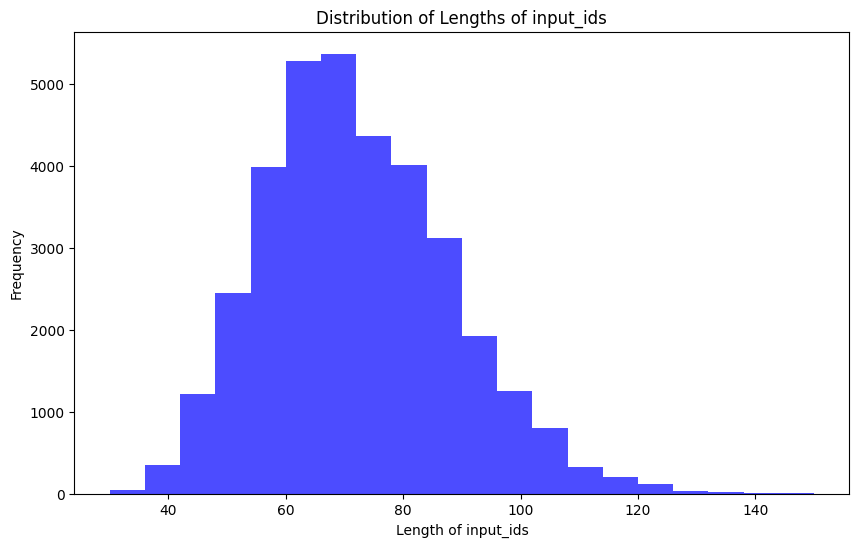

In [ ]:
import matplotlib.pyplot as plt

def tokenize_prompt_wo_pad(prompt):
    return tokenizer(format_prompt(prompt))

tokenized_train_dataset = map(tokenize_prompt_wo_pad, train_dataset)
tokenized_val_dataset = map(tokenize_prompt_wo_pad, eval_dataset)

def plot_data_lengths(tokenize_train_dataset, tokenized_val_dataset):
    """ Check the distribution of the lengths of the tokenized prompts """
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [ ]:
max_length = 256

def tokenize_prompt(prompt):
    result = tokenizer(format_prompt(prompt), truncation=True, max_length=max_length, padding="max_length")
    result["labels"] = result["input_ids"].copy()
    return result


tokenized_train_dataset = list(map(tokenize_prompt, train_dataset))
tokenized_val_dataset = list(map(tokenize_prompt, eval_dataset))

# Setup qLoRA

In [ ]:
from transformers import AutoTokenizer

def test_model(model, prompt):
  tokenizer = AutoTokenizer.from_pretrained(
      base_model_id,
      add_bos_token=True,
  )

  model_input = tokenizer(prompt, return_tensors="pt").to("cuda")

  model.eval() # switches the model into evaluation mode, disables things like dropout
  with torch.no_grad():
    response = tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True)

  return response
  divider = '# Kubectl command: '
  last_t = response.index(divider)
  response = response[last_t + len(divider) + 1:]


In [ ]:
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-Instruct-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# PEFT

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=64,
    lora_alpha=16,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)


In [ ]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

In [ ]:
from peft import prepare_model_for_kbit_training

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)
model.gradient_checkpointing_enable()

model = prepare_model_for_kbit_training(model)
print(model)

model = get_peft_model(model, config)
print_stats(model)

print(model)
model = accelerator.prepare_model(model)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )

In [ ]:
import transformers
from trl import SFTTrainer

project = "KubeMistral"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name
#IDK
torch.utils.checkpoint.use_reentrant=True
# tokenizer.deprecation_warnings["Asking-to-pad-a-fast-tokenizer"] = True

trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    formatting_func=lambda x: x,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=16,
        gradient_accumulation_steps=1,
        max_steps=2000,
        learning_rate=2e-4, # Want a small lr for finetuning
        # bf16=True,
        fp16=True,
        optim="paged_adamw_32bit",
        weight_decay=0.001,
        max_grad_norm=0.3,
        logging_steps=200,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=200,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=200,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        lr_scheduler_type="constant",
        report_to="tensorboard",
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
    packing=True,
    tokenizer=tokenizer,
    max_seq_length=256,
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:234: UserWarning: You passed `packing=True` to the SFTTrainer, and you are training your model with `max_steps` strategy. The dataset will be iterated until the `max_steps` are reached.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:570: UserWarning: The dataset reached end and the iterator is reset to the start.
  warnings.warn("The dataset reached end and the iterator is reset to the start.")
You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current be

Step,Training Loss,Validation Loss
200,0.614200,0.478392
400,0.436300,0.440760
600,0.408700,0.430510
800,0.395600,0.423964
1000,0.385300,0.423242
1200,0.378200,0.423642
1400,0.373400,0.420162
1600,0.365100,0.418201
1800,0.360800,0.425426
2000,0.353300,0.433914


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

TrainOutput(global_step=2000, training_loss=0.4070881233215332, metrics={'train_runtime': 8685.8161, 'train_samples_per_second': 3.684, 'train_steps_per_second': 0.23, 'total_flos': 3.578630504448e+17, 'train_loss': 0.4070881233215332, 'epoch': 0.93})

In [ ]:
test_model(model, "<s>[INST] what is the capital of Hungary [/INST]")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


'[INST] what is the capital of Hungary [/INST] The capital of Hungary is Budapest.'

In [ ]:
model.push_to_hub('ComponentSoft/mistral-kubectl-instruct')
tokenizer.push_to_hub('ComponentSoft/mistral-kubectl-instruct')

adapter_model.bin:   0%|          | 0.00/680M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ComponentSoft/mistral-kubectl-instruct/commit/e42eb8b837fad840d749668564e5fa9f604f49ed', commit_message='Upload tokenizer', commit_description='', oid='e42eb8b837fad840d749668564e5fa9f604f49ed', pr_url=None, pr_revision=None, pr_num=None)